In [ ]:
import pandas as pd
import os
os.environ["AWS_PROFILE"] = "hyrox-results"
os.environ["AWS_DEFAULT_REGION"] = "eu-west-2"


uri = "s3://hyrox-results/processed/parquet/season=8/2025_Poznan__LR3MS4JI11E7.parquet"
df = pd.read_parquet(uri, engine="pyarrow")

col = "work_1"   # change to work_1, total_time, etc.

print(df[col].dtype)
print(df[col].dropna().head(10).map(lambda x: (type(x), repr(x))).to_list())


object
[(<class 'str'>, "'0:04:16'"), (<class 'str'>, "'0:04:14'"), (<class 'str'>, "'0:04:12'"), (<class 'str'>, "'0:04:10'"), (<class 'str'>, "'0:04:19'"), (<class 'str'>, "'0:04:15'"), (<class 'str'>, "'0:04:12'"), (<class 'str'>, "'0:04:10'"), (<class 'str'>, "'0:04:22'"), (<class 'str'>, "'0:04:19'")]


In [ ]:
import duckdb
from scripts.sql_queries import MACRO
col = "work_1"   # or "run_1", etc.

con = duckdb.connect()
con.execute(MACRO)          # your MACRO string
con.register("t", df)       # expose pandas df as a DuckDB table

res = con.execute(f"""
SELECT
  {col} AS raw_value,
  typeof({col}) AS raw_type,
  trim(CAST({col} AS VARCHAR)) AS s,
  regexp_matches(trim(CAST({col} AS VARCHAR)), '^[0-9]+:[0-9]{{2}}:[0-9]{{2}}$') AS matches_hms,
  regexp_matches(trim(CAST({col} AS VARCHAR)), '^[0-9]+:[0-9]{{2}}$') AS matches_ms,
  time_to_min({col}) AS seconds
FROM t
WHERE {col} IS NOT NULL
LIMIT 50;
""").df()

res


In [1]:
from pyrox import PyroxClient
client = PyroxClient()
client.list_races(season=7, force_refresh=True)


,season,location,file_last_modified
0,7,amsterdam,2026-01-03T17:18:05+00:00
1,7,anaheim,2026-01-03T15:47:26+00:00
2,7,atlanta,2026-01-03T12:02:23+00:00
3,7,auckland,2026-01-03T15:16:53+00:00
4,7,bangkok,2026-01-03T12:42:30+00:00
...,...,...,...
60,7,toronto,2026-01-03T17:24:46+00:00
61,7,toulouse,2026-01-03T15:12:50+00:00
62,7,valencia,2026-01-03T12:05:34+00:00
63,7,vienna,2026-01-03T14:57:04+00:00


Checking which events have only '3' divsions available to them.

In [ ]:
all_s8 = client.get_season(season=8, use_cache=False)
divs_by_event = (
    all_s8.dropna(subset=["event_name", "division"])
      .groupby("event_name")["division"]
      .apply(lambda x: sorted(set(x)))
      .reset_index(name="divisions")
)
events_len_3 = (
    divs_by_event.assign(n_divisions=divs_by_event["divisions"].str.len())
                .loc[lambda d: d["n_divisions"] == 3, "event_name"]
                .tolist()
)
events_len_3

In [ ]:
all_s8.loc[all_s8["division"] == 'pro_doubles']

all_s8.columns

In [ ]:
import duckdb
import pandas as pd

con = duckdb.connect("pyrox_duckdb", read_only=True)
# quick smoke test
print(con.execute("SHOW TABLES").fetchall())
print(con.execute("SELECT COUNT(*) FROM race_results").fetchone())

df = con.execute("""
  SELECT *
  FROM race_results
  WHERE total_time_s IS NOT NULL
  LIMIT 1000
""").fetchdf()

df

In [ ]:
from typing import Sequence, Any

def get_athlete_races(con: duckdb.DuckDBPyConnection, athlete_name: str) -> Sequence[Any]:
    sql = """
    SELECT r.*
    FROM athlete_results ar
    JOIN athletes a ON a.athlete_id = ar.athlete_id
    JOIN race_results r ON r.result_id = ar.result_id
    WHERE a.canonical_name = lower(trim(?))
    ORDER BY r.season DESC, r.year DESC, r.event_name;
    """
    return con.execute(sql, [athlete_name]).fetchall()

In [ ]:
races = (get_athlete_races(con, 'INGHAM, JAMES'))


In [ ]:
pd.DataFrame(races)

In [1]:
from pyrox.reporting import ReportingClient
import pandas as pd 

reports = ReportingClient(database="pyrox_duckdb")

## Report Flow

1. Type your name and get a possible list of results

In [2]:
reports.search_athlete_races("kate russell", require_unique=False) 

,result_id,season,location,year,age_group,division,event_id,event_name,gender,name_raw,...,total_time_min,skiErg_time_min,sledPush_time_min,sledPull_time_min,burpeeBroadJump_time_min,rowErg_time_min,farmersCarry_time_min,sandbagLunges_time_min,wallBalls_time_min,work_time_min
0,cf1ed0f0ab5780895fa6205892a19cf3,7,madrid,2024,XU29,doubles,JGDMS4JI8EA,2024 Madrid,mixed,"Vlad Matei, Kate Russell",...,75.316667,4.233333,2.966667,4.450000,2.966667,4.466667,1.650000,3.766667,4.366667,28.866667
1,4cdfc90a9b32edfa525ef0b8d4c2c27d,8,london-excel,2025,25-29,open,LR3MS4JI10F6,2025 London Excel,female,"Russell, Kate",...,86.516667,5.633333,2.583333,7.883333,6.350000,5.783333,3.683333,4.066667,6.533333,42.516667


2. From the given results, click on the one you want a report on.
    Behind the scenes, we will get the result_id of that, and location, season, year, division and age_group?
    

In [3]:
athlete_id = "cf1ed0f0ab5780895fa6205892a19cf3"


test = reports.race_report(athlete_id)
print(test.keys())


test['splits']

dict_keys(['race', 'cohort', 'splits', 'cohort_splits', 'cohort_time_window', 'cohort_time_window_splits'])


,split_name,split_time_min,split_rank,split_size,split_percentile,split_percentile_time_window
0,burpee_broad_jump,2.966667,77,179,0.584270,0.722656
1,farmers_carry,1.650000,58,179,0.696629,0.702148
2,row_erg,4.466667,47,179,0.741573,0.698242
3,roxzone,6.816667,53,179,0.707865,0.535156
4,run_1,5.783333,62,179,0.662921,0.319336
5,run_2,4.800000,61,179,0.679775,0.293945
6,run_3,4.783333,31,179,0.831461,0.575195
7,run_4,4.733333,29,179,0.842697,0.605469
8,run_5,4.816667,30,179,0.837079,0.618164
9,run_6,4.883333,42,179,0.769663,0.500977


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'sledPush_time_min distribution - madrid - season 7 - +/-5m total_time'}, xlabel='sledPush_time_min (minutes)', ylabel='count'>)

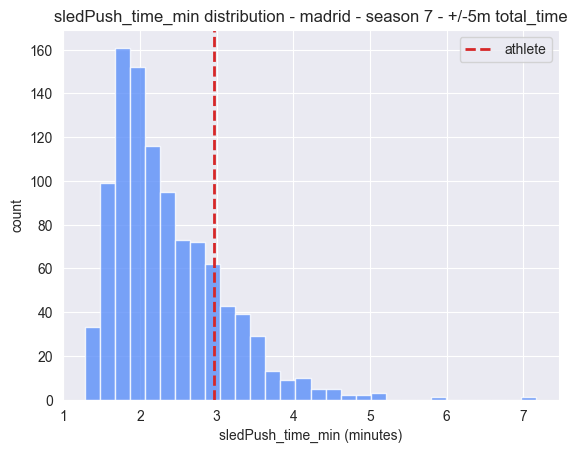

In [5]:
reports.plot_cohort_distribution(athlete_id, metric="sledPush", cohort_mode="time_window")

We now have a list of other athletes that have raced in the same division. We want to evaluate this current's set of athletes performance against the other guys -- where are they losing time?

We will also have an optimiser trained? And that optimiser may use the whole set of the season's data, from which the optimiser will know exactly what to look for in generating recommendations.

Where are you versus people in the 5 minute range above you? 

If you were to keep your running times the same -- what should happen to your stations? What would that mean? How far would that push your stations?

If you were to keep your station times the same -- what should happen to your runs? What would that mean? How far would that push you up the running?

We have identified a 'cohort' based on network science / engine / station times for you. What do the top performers in that cohort do versus you? Where are you lacking?

I have my data -- I need to:

1) Assign myself a run engine
2) Assign myself a station engine

Evaluate myself against people in the (my_time;- 5 mins) range -- and clearly understand what went wrong / what went right / what could be improved